In [1]:
!pip install pymovements
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.6/327.6 kB 8.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 72.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 110.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 53.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.7/411.7 kB 26.3 MB/s eta 0:00:00
  Attempting uninstall: polars
    Found existing installation: polars 1.25.0
    Uninstalling polars-1.25.0:
      Successfully uninstalled polars-1.25.0
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.2
    Uninstalling matplotlib-3.7.2:
      Successfully uninstalled matplotlib-3.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0

In [2]:
import pymovements as pm
dataset = pm.Dataset('ETDD70', path='data/ETDD70')

dataset.download()

edd_raw.zip: 0.00B [00:00, ?B/s]

Checking integrity of edd_raw.zip


edd_fix.zip: 0.00B [00:00, ?B/s]

Checking integrity of edd_fix.zip
Extracting edd_raw.zip to data/ETDD70/raw


100%|██████████| 8/8 [00:00<00:00, 5193.38it/s]


Extracting edd_fix.zip to data/ETDD70/precomputed_events


100%|██████████| 8/8 [00:00<00:00, 4853.82it/s]


In [3]:
# Block 1 (Webcam Adapted): Setup and Helper Function
# Purpose: Import libraries, define constants, and create a robust function to process the data.

import os
import glob
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("--- Block 1 (Webcam Adapted): Setup and Helper Function ---")

# --- 1. Define Constants and Paths ---
BASE_PATH = '/kaggle/working/data/ETDD70/precomputed_events'
DATA_PATH = os.path.join(BASE_PATH, 'data/data')
LABELS_FILE = os.path.join(BASE_PATH, 'dyslexia_class_label.csv')

# Screen properties for ETDD70 (for spatial normalization)
SCREEN_WIDTH_PX = 1680
SCREEN_HEIGHT_PX = 1050
SCREEN_DIAGONAL_PX = np.sqrt(SCREEN_WIDTH_PX**2 + SCREEN_HEIGHT_PX**2)

# Sequencing parameters
SEQUENCE_LENGTH = 20
STEP = 5

# --- 2. Load Essential Assets (UPDATED FOR WEBCAM MODEL) ---
try:
    # Load the NEW scaler for webcam model
    with open('/kaggle/input/language-encoder/tensorflow2/default/1/scaler_v2.pkl', 'rb') as f:
        scaler = pickle.load(f)
    print("Loaded scaler_v2.pkl for webcam model.")

    labels_df = pd.read_csv(LABELS_FILE)
    labels_df.rename(columns={'subject_id': 'participant_id', 'label': 'dyslexia_label_str'}, inplace=True)
    labels_df['dyslexia_label'] = labels_df['dyslexia_label_str'].apply(lambda x: 0 if x == 'non-dyslexic' else 1)
    labels_df.set_index('participant_id', inplace=True)
    print("Loaded dyslexia labels.")

except FileNotFoundError as e:
    print(f"ERROR: A required file is missing. {e}")
    scaler = None
    labels_df = None

# --- 3. Define a Reusable Data Processing Function (UPDATED FOR WEBCAM MODEL) ---
def process_task_for_participant(participant_id, task_name):
    """
    Loads, harmonizes, scales, and creates sequences for one task for one participant.
    ADAPTED FOR WEBCAM MODEL: 
    - Removed saccade_velocity_in
    - Added IS_REGRESSION feature
    - Relaxed fixation duration filter to (50, 1500)
    """
    # Find the relevant fixation and saccade files
    fix_file_pattern = os.path.join(DATA_PATH, f'Subject_{participant_id}_*_{task_name}_fixations.csv')
    sacc_file_pattern = os.path.join(DATA_PATH, f'Subject_{participant_id}_*_{task_name}_saccades.csv')

    fix_file = glob.glob(fix_file_pattern)
    sacc_file = glob.glob(sacc_file_pattern)

    if not fix_file or not sacc_file:
        return np.array([]) # Return empty array if data is missing for this task

    # Load data and strip whitespace from column names to prevent KeyErrors
    fix_df = pd.read_csv(fix_file[0])
    fix_df.columns = fix_df.columns.str.strip()
    sacc_df = pd.read_csv(sacc_file[0])
    sacc_df.columns = sacc_df.columns.str.strip()

    # Align saccade data with the FOLLOWING fixation
    sacc_df_shifted = sacc_df.shift(1)

    # Combine the necessary columns into a new DataFrame
    # NOTE: saccade_velocity_in is REMOVED
    trial_df = pd.DataFrame({
        'fixation_duration': fix_df['duration_ms'],
        'fixation_x': fix_df['fix_x'],
        'fixation_y': fix_df['fix_y'],
        'saccade_amplitude_in': sacc_df_shifted['ampl']
    })

    # Clean and Normalize
    trial_df.fillna(0, inplace=True)
    
    # UPDATED FILTER: Changed from (80, 1000) to (50, 1500)
    trial_df = trial_df[trial_df['fixation_duration'].between(50, 1500)].copy()

    # Perform spatial normalization
    trial_df['x_norm'] = trial_df['fixation_x'] / SCREEN_WIDTH_PX
    trial_df['y_norm'] = trial_df['fixation_y'] / SCREEN_HEIGHT_PX
    trial_df['amp_norm'] = trial_df['saccade_amplitude_in'] / SCREEN_DIAGONAL_PX

    # NEW FEATURE: Add IS_REGRESSION binary feature
    # Detect regressions: when a saccade moves backwards (negative amplitude in reading direction)
    # For left-to-right reading, we can approximate this by checking if the next fixation x is less than current
    trial_df['IS_REGRESSION'] = 0
    for i in range(len(trial_df) - 1):
        if trial_df.iloc[i+1]['fixation_x'] < trial_df.iloc[i]['fixation_x']:
            trial_df.iloc[i+1, trial_df.columns.get_loc('IS_REGRESSION')] = 1

    # UPDATED FEATURE SET: Apply the Phase 2 scaler to the NEW harmonized features
    # Features: fixation_duration, x_norm, y_norm, amp_norm, IS_REGRESSION (no saccade_velocity_in)
    kinematic_features = ['fixation_duration', 'x_norm', 'y_norm', 'amp_norm', 'IS_REGRESSION']

    # Ensure the dataframe has the columns in the correct order for the scaler
    feature_df = trial_df[kinematic_features]
    scaled_features = scaler.transform(feature_df)

    # Create sequences from the SCALED features
    sequences = []
    for i in range(0, len(scaled_features) - SEQUENCE_LENGTH + 1, STEP):
        sequences.append(scaled_features[i:i+SEQUENCE_LENGTH])

    return np.array(sequences)

print("Setup complete. Helper function is ready for webcam model.")
# --- End of Block 1 ---
print("\n" + "="*50 + "\n")

2025-11-18 16:10:29.628501: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763482229.818001      39 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763482229.867922      39 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


--- Block 1 (Webcam Adapted): Setup and Helper Function ---
Loaded scaler_v2.pkl for webcam model.
Loaded dyslexia labels.
Setup complete. Helper function is ready for webcam model.




In [4]:
# Block 2 (Webcam Adapted): Build the "Participant Packets"
# Purpose: Iterate through all participants and create a single data sample for each,
# containing their sequences for ONLY Meaningful Text (NO Pseudo, NO Syllables).

print("--- Block 2 (Webcam Adapted): Building Participant Packets ---")
participant_packets = []
all_participant_ids = sorted(labels_df.index.unique())

if scaler and labels_df is not None:
    for pid in all_participant_ids:
        print(f"Processing participant {pid}...")

        # Process ONLY the Meaningful Text task (Pseudo and Syllables tasks are DROPPED)
        seq_meaningful = process_task_for_participant(pid, 'Meaningful_Text')

        # Get the dyslexia label for this participant
        label = labels_df.loc[pid]['dyslexia_label']

        # Store the results as a packet (ONLY meaningful text)
        participant_packets.append({
            'participant_id': pid,
            'sequences_meaningful': seq_meaningful,
            'label': label
        })

    print("\nAll participants processed.")

    # --- Find the max sequence length for padding ---
    max_len = 0
    for packet in participant_packets:
        max_len = max(max_len, len(packet['sequences_meaningful']))
    print(f"Determined max sequence length for padding: {max_len}")

    # --- Assemble final padded NumPy arrays ---
    final_data = {
        'meaningful': [],
        'labels': []
    }
    # Define the target shape for each participant's task data
    # NOTE: Feature dimension is now 5 (was 5 before, still 5 with new feature set)
    target_shape = (max_len, SEQUENCE_LENGTH, 5)

    for packet in participant_packets:
        # Manual Padding Logic for Meaningful task only
        sequences = packet['sequences_meaningful']
        num_sequences = sequences.shape[0]

        # Create an empty, zero-filled array of the target shape
        padded_array = np.zeros(target_shape, dtype='float32')

        if num_sequences > 0:
            # Determine how many sequences to copy (handle truncation)
            num_to_copy = min(num_sequences, max_len)
            # Copy the actual data into the padded array
            padded_array[:num_to_copy] = sequences[:num_to_copy]

        final_data['meaningful'].append(padded_array)
        final_data['labels'].append(packet['label'])

    # Convert lists to final NumPy arrays (ONLY meaningful text)
    X_mean = np.array(final_data['meaningful'])
    y = np.array(final_data['labels'])

    print("\nFinal dataset assembled and padded.")
    print(f"Shape of MeaningfulText data (X_mean): {X_mean.shape}")
    print(f"Shape of labels (y): {y.shape}")

# --- End of Block 2 ---
print("\n" + "="*50 + "\n")

--- Block 2 (Webcam Adapted): Building Participant Packets ---
Processing participant 1003...
Processing participant 1009...
Processing participant 1016...
Processing participant 1019...
Processing participant 1021...
Processing participant 1033...


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Processing participant 1038...
Processing participant 1040...
Processing participant 1058...
Processing participant 1065...
Processing participant 1073...
Processing participant 1075...
Processing participant 1082...


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/p

Processing participant 1090...
Processing participant 1095...
Processing participant 1109...
Processing participant 1113...
Processing participant 1115...
Processing participant 1134...
Processing participant 1145...


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/p

Processing participant 1160...
Processing participant 1166...
Processing participant 1169...
Processing participant 1174...
Processing participant 1186...
Processing participant 1187...
Processing participant 1189...


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/p

Processing participant 1209...
Processing participant 1235...
Processing participant 1254...
Processing participant 1255...
Processing participant 1257...
Processing participant 1258...
Processing participant 1263...


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/p

Processing participant 1271...
Processing participant 1274...
Processing participant 1284...
Processing participant 1300...
Processing participant 1312...
Processing participant 1314...


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Processing participant 1318...
Processing participant 1322...
Processing participant 1345...
Processing participant 1349...
Processing participant 1350...
Processing participant 1377...


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/p

Processing participant 1380...
Processing participant 1398...
Processing participant 1405...
Processing participant 1417...
Processing participant 1421...
Processing participant 1459...


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Processing participant 1476...
Processing participant 1571...
Processing participant 1582...
Processing participant 1591...
Processing participant 1626...


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Processing participant 1693...
Processing participant 1729...
Processing participant 1744...
Processing participant 1760...
Processing participant 1858...


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Processing participant 1859...
Processing participant 1869...
Processing participant 1879...
Processing participant 1903...
Processing participant 1913...


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Processing participant 1929...
Processing participant 1993...
Processing participant 1996...

All participants processed.
Determined max sequence length for padding: 82

Final dataset assembled and padded.
Shape of MeaningfulText data (X_mean): (70, 82, 20, 5)
Shape of labels (y): (70,)




/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [5]:
# Block 3 (Webcam Adapted): Build the 1-Input "Reading Profile" Model
# Purpose: Construct the advanced Keras model with ONE input branch (only Meaningful Text).

from tensorflow.keras.layers import Input, Dense, Dropout, TimeDistributed, GlobalAveragePooling1D
from tensorflow.keras.models import Model, load_model

print("--- Block 3 (Webcam Adapted): Building the 1-Input Model ---")

if 'max_len' in locals():
    # --- 1. Load the shared encoder (WEBCAM VERSION) and freeze it ---
    encoder = load_model('/kaggle/input/language-encoder/tensorflow2/default/1/gaze_encoder_v2.h5')
    
    # Build the encoder with the correct input shape to initialize all variables
    dummy_input = tf.zeros((1, SEQUENCE_LENGTH, 5))
    _ = encoder(dummy_input)
    
    # Now freeze it
    encoder.trainable = False
    print("Loaded, built, and froze pre-trained encoder (gaze_encoder_v2.h5).")

    # --- 2. Define the SINGLE input layer (ONLY Meaningful Text) ---
    input_meaningful = Input(shape=(max_len, SEQUENCE_LENGTH, 5), name='input_meaningful')

    # --- 3. Create a TimeDistributed layer to apply the encoder to each sequence ---
    shared_encoder = TimeDistributed(encoder, name='shared_gaze_encoder')

    # --- 4. Process the input stream through the shared encoder ---
    encoded_mean = shared_encoder(input_meaningful)

    # --- 5. Aggregate the embeddings for the task profile ---
    # GlobalAveragePooling1D will average the 64-dim embeddings across the 'max_len' dimension
    profile_mean = GlobalAveragePooling1D(name='profile_meaningful')(encoded_mean)

    # --- 6. Use the single profile vector directly (no concatenation needed) ---
    # profile_mean is now our main feature vector

    # --- 7. Add the final classification head ---
    x = Dense(64, activation='relu', name='head_dense_1')(profile_mean)
    x = Dropout(0.5, name='head_dropout')(x)
    output = Dense(1, activation='sigmoid', name='output_classifier')(x)

    # --- 8. Create and compile the final model (1-INPUT MODEL) ---
    profile_model = Model(
        inputs=input_meaningful,  # Single input now
        outputs=output
    )
    profile_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print("\n1-Input 'Reading Profile' model built and compiled successfully.")
    profile_model.summary()

# --- End of Block 3 ---
print("\n" + "="*50 + "\n")

--- Block 3 (Webcam Adapted): Building the 1-Input Model ---


I0000 00:00:1763482298.520131      39 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1763482299.986266     119 cuda_dnn.cc:529] Loaded cuDNN version 90300


Loaded, built, and froze pre-trained encoder (gaze_encoder_v2.h5).

1-Input 'Reading Profile' model built and compiled successfully.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_meaningful (InputLayer)   │ (None, 82, 20, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ shared_gaze_encoder             │ (None, 82, 64)         │       118,016 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ profile_meaningful              │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ head_dense_1 (Dense)            │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ head_dropout (Dropout)          │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_classifier (Dense)       │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,241 (477.50 KB)

 Trainable params: 4,225 (16.50 KB)

 Non-trainable params: 118,016 (461.00 KB)

--- Block 4 (Webcam Adapted): Training and Evaluating the Profile Model ---
Data split into 52 training and 18 validation participants.
Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.5790 - loss: 0.6908 - val_accuracy: 0.5000 - val_loss: 0.6841
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.5053 - loss: 0.6891 - val_accuracy: 0.6667 - val_loss: 0.6732
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.4804 - loss: 0.6968 - val_accuracy: 0.7778 - val_loss: 0.6646
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.4714 - loss: 0.6892 - val_accuracy: 0.9444 - val_loss: 0.6568
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.6026 - loss: 0.6633 - val_accuracy: 0.9444 - val_loss: 0.6508
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.6716 - loss: 0.6482 - val_accuracy: 0.7778 - val_loss: 0.6449
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.5314 - loss: 0.6760 - val_accuracy: 0.8

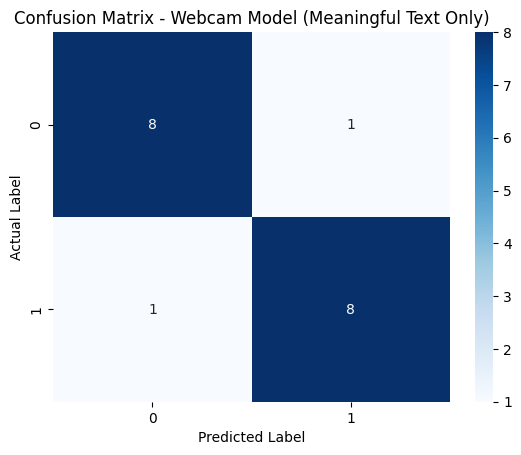

In [6]:
# Block 4 (Webcam Adapted): Train and Evaluate the Profile Model
# Purpose: Split the participant-level data, train the model, and evaluate its performance.
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("--- Block 4 (Webcam Adapted): Training and Evaluating the Profile Model ---")

if 'profile_model' in locals():
    # --- 1. Split participant data for training and validation ---
    indices = np.arange(len(y))
    train_indices, val_indices = train_test_split(indices, test_size=0.25, random_state=42, stratify=y)

    # Create the training data (SINGLE input only - meaningful text)
    X_train = X_mean[train_indices]
    y_train = y[train_indices]

    # Create the validation data (SINGLE input only - meaningful text)
    X_val = X_mean[val_indices]
    y_val = y[val_indices]

    print(f"Data split into {len(y_train)} training and {len(y_val)} validation participants.")

    # --- 2. Train the model ---
    history = profile_model.fit(
        X_train, y_train,
        epochs=500,
        batch_size=8,
        validation_data=(X_val, y_val),
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        ]
    )

    # --- 3. Evaluate the final model on the validation set ---
    print("\n--- Final Model Evaluation on Validation Set ---")
    y_pred_proba = profile_model.predict(X_val)
    y_pred_class = (y_pred_proba > 0.5).astype(int)

    print("\nClassification Report:")
    print(classification_report(y_val, y_pred_class, target_names=['Non-Dyslexic', 'Dyslexic']))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_val, y_pred_class)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Webcam Model (Meaningful Text Only)')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# --- End of Block 4 ---

In [7]:
# Block 5: Saving the Final Model
# Purpose: Save the best performing model to a file for future use in a real application.

print("--- Block 5: Saving the Final Model ---")

if 'profile_model' in locals():
    # Because we used `restore_best_weights=True` in our EarlyStopping callback,
    # the 'profile_model' object in memory is already loaded with the weights
    # from the best performing epoch. We can now save it directly.

    model_filename = 'dyslexia_profile_model.h5'
    profile_model.save(model_filename)

    print(f"\n✅ Success! The best performing model has been saved to '{model_filename}'.")
    print("This file contains the complete architecture and learned weights.")

else:
    print("Error: 'profile_model' not found in memory. Please re-run the training block.")

# --- End of Block 5 ---


--- Block 5: Saving the Final Model ---

✅ Success! The best performing model has been saved to 'dyslexia_profile_model.h5'.
This file contains the complete architecture and learned weights.


--- Block 6: Visualizing Training History ---
Successfully saved training history plots to 'training_history_plots.png'


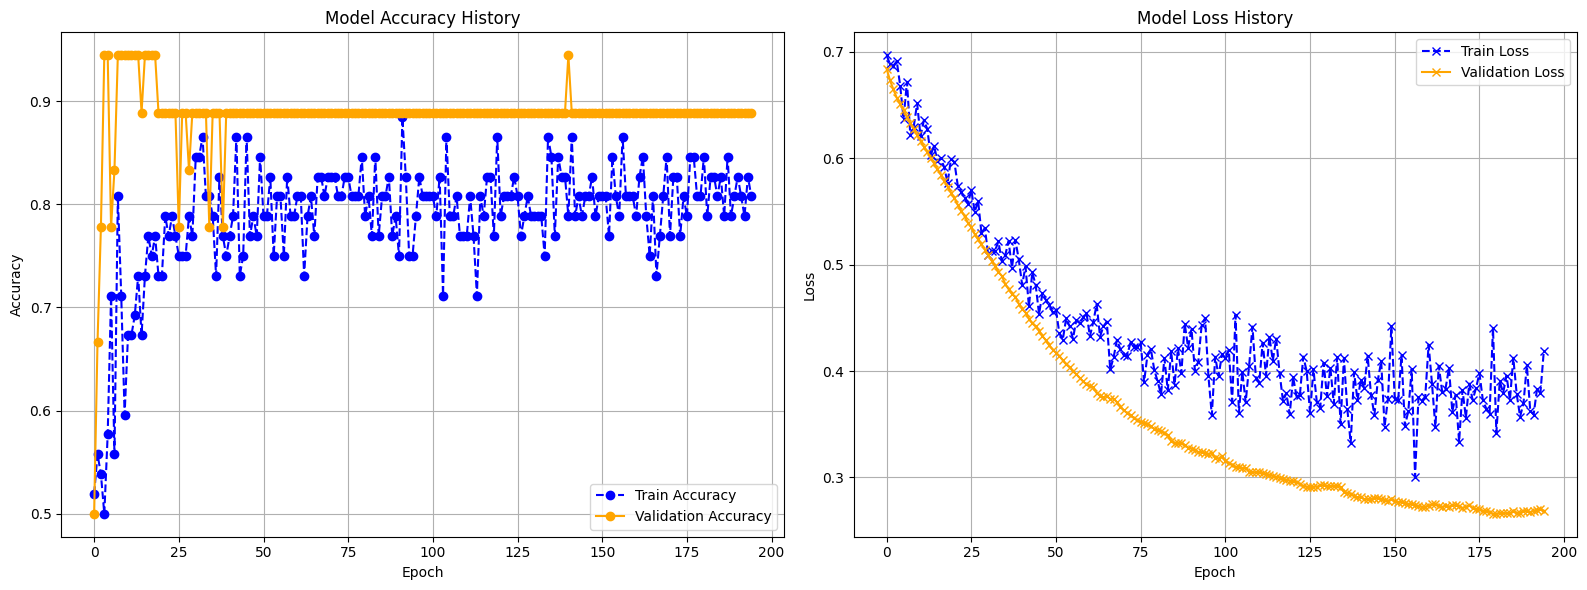

In [8]:
# Block 6: Visualize Training and Validation History
# Purpose: Plot the accuracy and loss curves to understand the model's learning process.

import matplotlib.pyplot as plt

print("--- Block 6: Visualizing Training History ---")

if 'history' in locals():
    # The 'history' object was returned by the model.fit() command.
    # It contains the metrics from each epoch.

    # Create a figure with two subplots side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # --- Plot 1: Accuracy History ---
    ax1.plot(history.history['accuracy'], label='Train Accuracy', color='blue', marker='o', linestyle='--')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', marker='o')
    ax1.set_title('Model Accuracy History')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')
    ax1.grid(True)

    # --- Plot 2: Loss History ---
    ax2.plot(history.history['loss'], label='Train Loss', color='blue', marker='x', linestyle='--')
    ax2.plot(history.history['val_loss'], label='Validation Loss', color='orange', marker='x')
    ax2.set_title('Model Loss History')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('training_history_plots.png')
    print("Successfully saved training history plots to 'training_history_plots.png'")
    plt.show()

else:
    print("Error: 'history' object not found. Please make sure the model training block has been run.")

# --- End of Block 6 ---
